In [39]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hannahjoshua/nltk_data...


True

In [40]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [2]:
df = pd.read_csv("reframing_dataset.csv")

df.head()

,situation,thought,reframe,thinking_traps_addressed
0,A Roomate of mine stole my comptuer,Someone I trusted stole something valuable of ...,"My roommate stole something of mine, and I wil...",emotional reasoning
1,A Roomate of mine stole my comptuer,Someone I trusted stole something valuable of ...,While I would like there to be consequences fo...,emotional reasoning
2,"A few days ago, I got angry at my husband's gr...",She doesn't respect me.,She is older and may have been tired,overgeneralizing
3,"A few days ago, I got angry at my husband's gr...",She doesn't respect me.,"I felt disrespected by her actions, but that d...",overgeneralizing
4,A friend who is a recent widower has started d...,My friend is ignoring his recently-deceased wife.,Maybe my friend is in a healthy spot to date n...,disqualifying the positive


In [3]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (600, 4)
Columns: ['situation', 'thought', 'reframe', 'thinking_traps_addressed']


In [10]:
# Data types and non-null counts
print("\nDataset Info:")
df.info()

# Missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

print(df.columns.tolist())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   situation                 600 non-null    object
 1   thought                   600 non-null    object
 2   reframe                   600 non-null    object
 3   thinking_traps_addressed  600 non-null    object
dtypes: object(4)
memory usage: 18.9+ KB

Missing Values:
situation                   0
thought                     0
reframe                     0
thinking_traps_addressed    0
dtype: int64

Duplicate Rows: 0
['situation', 'thought', 'reframe', 'thinking_traps_addressed']


In [11]:
print(df['thought'].value_counts(dropna=False))
print(df['reframe'].value_counts(dropna=False))
print(df['thinking_traps_addressed'].value_counts(dropna=False))

thought
I'm worthless                                                              10
No one cares about me                                                      10
I am scared something bad will happen to the people I love                  4
I'm a failure                                                               4
I feel like a failure                                                       4
                                                                           ..
I want to die                                                               2
That I'm going to fail                                                      2
I keep failing at this                                                      2
People will never perceive me as acting naturally in social situations.     2
maybe she doesn't like me anymore.                                          2
Name: count, Length: 286, dtype: int64
reframe
My roommate stole something of mine, and I will focus on actionable solutions to addres

In [12]:
for col in ['situation', 'thought', 'reframe']:
    empty_count = df[col].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()
    print(f"Empty strings in '{col}':", empty_count)

Empty strings in 'situation': 0
Empty strings in 'thought': 0
Empty strings in 'reframe': 0


In [13]:
df.columns = df.columns.str.strip().str.lower()

# Clean whitespace from all string fields
for col in ['situation', 'thought', 'reframe', 'thinking_traps_addressed']:
    df[col] = df[col].astype(str).str.strip()

In [14]:
# Add columns to measure length of each text entry
df['thought_length'] = df['thought'].apply(len)
df['reframe_length'] = df['reframe'].apply(len)

# Show basic stats
df[['thought_length', 'reframe_length']].describe()

,thought_length,reframe_length
count,600.000000,600.000000
mean,40.266667,114.920000
std,29.161496,53.129196
min,8.000000,14.000000
25%,21.000000,75.000000
50%,32.000000,105.000000
75%,51.000000,146.000000
max,192.000000,283.000000


In [15]:
# Save for future modeling or embedding
df.to_csv("reframing_cleaned.csv", index=False)

In [20]:
trap_series = df["thinking_traps_addressed"].dropna().apply(lambda x: [t.strip() for t in x.split(",")])
all_traps = trap_series.explode()

# Count frequencies
trap_counts = all_traps.value_counts()
trap_counts.head()

thinking_traps_addressed
negative feeling or emotion    151
overgeneralizing               107
labeling                       102
all-or-nothing thinking         99
personalizing                   98
Name: count, dtype: int64

/var/folders/br/f7206zhd1jg1sk4fssqjr06r0000gn/T/ipykernel_67804/1019897493.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=trap_counts.index, x=trap_counts.values, palette="viridis")


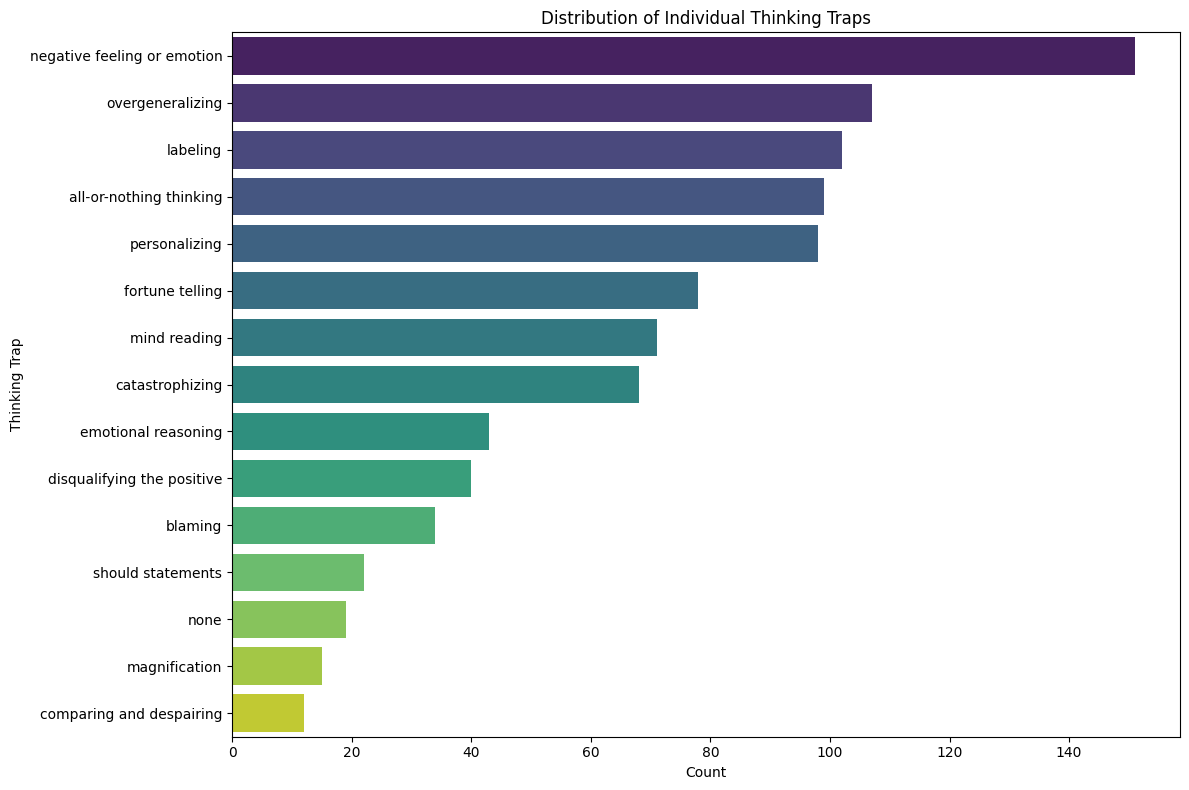

In [21]:
plt.figure(figsize=(12, 8))
sns.barplot(y=trap_counts.index, x=trap_counts.values, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Thinking Trap")
plt.title("Distribution of Individual Thinking Traps")
plt.tight_layout()
plt.show()

In [22]:
# Percentage distribution of each trap
trap_percent = (trap_counts / trap_counts.sum()) * 100

# Display traps that make up less than 2% of the dataset
trap_percent[trap_percent < 2].sort_values(ascending=False)

thinking_traps_addressed
none                        1.981230
magnification               1.564129
comparing and despairing    1.251303
Name: count, dtype: float64

In [46]:
def get_sentiment_score(text):
    if pd.isna(text):
        return None
    return sia.polarity_scores(str(text))['compound']

df['sentiment_thought'] = df['thought'].apply(get_sentiment_score)

df['sentiment_reframe'] = df['reframe'].apply(get_sentiment_score)


In [47]:
df['sentiment_shift'] = df['sentiment_reframe'] - df['sentiment_thought']

In [48]:
print("Average sentiment of original thoughts:", df['sentiment_thought'].mean())
print("Average sentiment of reframed thoughts:", df['sentiment_reframe'].mean())
print("Average sentiment improvement:", df['sentiment_shift'].mean())

Average sentiment of original thoughts: -0.21018833333333334
Average sentiment of reframed thoughts: 0.14660583333333332
Average sentiment improvement: 0.3567941666666667


In [49]:
# Most improved (biggest positive shift)
print(df.sort_values(by='sentiment_shift', ascending=False).head(5)[['thought', 'reframe', 'sentiment_shift']])

# Worsened (negative shift — reframe worse than thought)
print(df[df['sentiment_shift'] < 0].sort_values(by='sentiment_shift').head(5)[['thought', 'reframe', 'sentiment_shift']])

                                               thought  \
40                                     I hate everyone   
78   I thought that I should have studied harder. I...   
404                                 Never finding love   
18                                   Suicidal thoughts   
548                                      I'm a failure   

                                               reframe  sentiment_shift  
40   Some of the people in my life are mean to me. ...           1.5044  
78   I prepared for this exam, but the material was...           1.4508  
404  This person I liked didn't like me back.  I am...           1.4350  
18   Even very attractive people sometimes have a h...           1.4350  
548  There may be a good reason why they didn't kee...           1.4040  
                                    thought  \
111   My coworkers are making fun of me now   
146  I feel like I need to die to be happy.   
169        I'm being mean to someone I love   
385   I must not ha

In [50]:
trap_shift = df.groupby('thinking_traps_addressed')['sentiment_shift'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print(trap_shift)

                                                       mean  count
thinking_traps_addressed                                          
blaming,should statements                           1.45080      1
personalizing,catastrophizing                       1.37640      1
fortune telling,catastrophizing,all-or-nothing ...  1.36940      1
labeling,overgeneralizing,negative feeling or e...  1.32200      1
mind reading,labeling,negative feeling or emoti...  1.32025      2
...                                                     ...    ...
blaming,personalizing                              -0.65340      1
labeling,personalizing                             -0.69880      1
labeling,emotional reasoning                       -0.79230      1
overgeneralizing,mind reading                      -0.98580      1
negative feeling or emotion,catastrophizing        -1.07650      2

[131 rows x 2 columns]


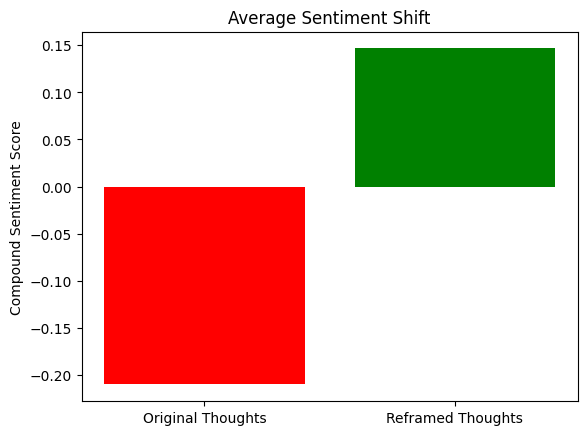

In [51]:
import matplotlib.pyplot as plt

plt.bar(['Original Thoughts', 'Reframed Thoughts'], [df['sentiment_thought'].mean(), df['sentiment_reframe'].mean()], color=['red', 'green'])
plt.title("Average Sentiment Shift")
plt.ylabel("Compound Sentiment Score")
plt.show()